In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

import numpy as np

from itertools import repeat

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from masterthesis.datasets import ReachCageDataset

In [2]:
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

## Simulate data

Idea: As we want to catch generalizations in the data with the core of our architecture and neuron-specific characteristics with the readout, we want to generate data mirroring this assumption about our data.

In [3]:
n_neurons = 10
n_time_bins = int(5500/100) # 100ms time bins over 5.4s in total

possible_neuron_specifics = torch.arange(-2, 3)
neuron_specifics = possible_neuron_specifics[torch.randint(0, len(possible_neuron_specifics), (n_neurons,))]
#neuron_specifics = torch.arange(-1, 2)
neuron_specifics = neuron_specifics.unsqueeze(1)

print(neuron_specifics.shape)
neuron_specifics.T

torch.Size([10, 1])


tensor([[-2,  2,  2,  1,  1,  1, -1, -1,  2,  0]])

In [4]:
raw_spikes = torch.arange(2, 4).float()
raw_spikes = raw_spikes.repeat((n_neurons, int(n_time_bins//len(raw_spikes))+1))
raw_spikes = raw_spikes[:,0:n_time_bins]

print(raw_spikes.shape)
raw_spikes[0,...]

torch.Size([10, 54])


tensor([2., 3., 2., 3., 2., 3., 2., 3., 2., 3., 2., 3., 2., 3., 2., 3., 2., 3.,
        2., 3., 2., 3., 2., 3., 2., 3., 2., 3., 2., 3., 2., 3., 2., 3., 2., 3.,
        2., 3., 2., 3., 2., 3., 2., 3., 2., 3., 2., 3., 2., 3., 2., 3., 2., 3.])

In [5]:
spikes = raw_spikes+neuron_specifics

print(spikes.shape)
spikes[0,...]

torch.Size([10, 54])


tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

In [6]:
X = spikes[:, 1:]

print(X.shape)
X[0,...]

torch.Size([10, 53])


tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

In [7]:
Y = spikes[:, :-1]

print(Y.shape)
Y[0,...]

torch.Size([10, 53])


tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.])

In [8]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [9]:
spikes_dataset = CustomDataset(X, Y)
batch_size = n_neurons
train_dataloader = DataLoader(spikes_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(spikes_dataset, batch_size=batch_size, shuffle=True)

## Model architecture

In [10]:
def elu1(x):
    return F.elu(x, inplace=True) + 1.

class Elu1(nn.Module):
    """
    Elu activation function shifted by 1 to ensure that the
    output stays positive. That is:

    Elu1(x) = Elu(x) + 1
    """

    def forward(self, x):
        return elu1(x)

In [11]:
class CoreAndReadout(nn.Module):
    def __init__(self, core, readout, nonlinearity=None):
        super().__init__()
        self.core = core
        self.readout = readout
        self.nonlinearity = elu1 if nonlinearity is None else nonlinearity
        
    def forward(self, x):
        latents = self.core(x)
        output = self.readout(latents)
        return self.nonlinearity(output), latents

In [12]:
class GRUCore(nn.Module):
    def __init__(self, hidden_size, bias=True):
        super().__init__()
        self.gru = nn.GRUCell(1, hidden_size, bias=bias)
        
    def init_state(self, batch_size):
        return nn.Parameter(torch.zeros([batch_size, self.gru.hidden_size]))
        
    def forward(self, x, hidden_state=None, reverse=True):
        if len(x.shape) != 2:
            raise RuntimeError(f"Expected 2D input to GRUCore, but got input of size: {x.shape}")
            
        hidden_states = []
        hidden_state = self.init_state(x.shape[0]) if hidden_state is None else hidden_state
        
        rng = range(x.shape[1])
        rng = reversed(rng) if reverse else rng
        
        for t in rng:
            input_ = x[:,t:t+1]
            hidden_state = self.gru(input_, hidden_state)
            hidden_states.append(hidden_state)
            
        hidden_states = torch.stack(hidden_states, 1)
        return hidden_states

In [13]:
class LinearReadout(nn.Module):
    def __init__(self, input_size, bias=True):
        super().__init__()
        self.linear = nn.Linear(input_size, 1, bias=bias)
        
    def forward(self, x):
        x = self.linear(x)
        return x.squeeze(dim=2)

## Training functions

In [14]:
def get_device(cpu_preference=False, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() and not cpu_preference else "cpu")
    if verbose: print("Using device:", device)
    return device

In [15]:
def accuracy(correct, total):
    return float(correct)/total

In [16]:
def train(dataloader, model, optimizer, loss_fn, scheduler=None, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    
    model.train()
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        y_pred, _ = model(x)
        
        loss = loss_fn(y_pred, y)
        epoch_loss.append(loss.item())
        
        y_pred = torch.round(y_pred)
        epoch_correct += sum((y == y_pred).flatten()).item()
        epoch_total += y.numel()
        
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)

In [17]:
def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            
            y_pred, _ = model(x)
            
            loss = loss_fn(y_pred, y)
            epoch_loss.append(loss.item())

            y_pred = torch.round(y_pred)
            epoch_correct += sum((y == y_pred).flatten())
            epoch_total += y.numel()
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)

In [18]:
def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, schedule_on_train=True, verbose=True):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    for epoch in range(num_epochs):
        epoch_train_loss, epoch_train_acc = train(train_dataloader, model, optimizer, loss_fn, scheduler, device)
        
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        if val_dataloader is not None:
            epoch_val_loss, epoch_val_acc = validate(val_dataloader, model, loss_fn, device)
        
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(epoch_train_acc if schedule_on_train or val_dataloader is None else epoch_val_acc)
            
        if epoch % 1000 == 0:
            val_str = f", val loss: {epoch_val_loss}, val acc: {epoch_val_acc}" if val_dataloader is not None else ""
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, train acc: {epoch_train_acc}{val_str}")
            
    return train_losses, train_accs, val_losses, val_accs

In [19]:
def plot(title, label, train_results, val_results=None):
    epoch_array = np.arange(len(train_results)) + 1
    train_label = "Training "+label.lower()
    val_label = "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, linestyle='dashed', marker='o')
    if val_results is not None: plt.plot(epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results'] if val_results is not None else ['Train results']
    
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    plt.show()

In [20]:
def inspect_predictions(dataloader, model, round_pred=True, plot_latent_space=False, device=None):
    lat_colors = ['r', 'g', 'b', 'y', 'm', 'c']
    
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            
            y_pred, y_lat = model(x)

            if round_pred: y_pred = torch.round(y_pred)
            print("Ground truths:", y[0,...])
            print("Predictions:", y_pred[0,...])
            
            criterion = nn.PoissonNLLLoss()
            epsilon = 1e-8
            loss = criterion((y_pred + epsilon).log(), (y + epsilon))
            print("Loss:", loss.item())
            
            print("Latents:", y_lat.shape)
            
            if plot_latent_space:
                y_lat = y_lat.numpy()
                x_coordinates = y_lat[:, :, 0].flatten()
                y_coordinates = y_lat[:, :, 1].flatten()

                neuron_category = neuron_specifics.flatten().numpy()
                colors = [lat_colors[spec_id] for spec_id in neuron_category]
                colors = np.repeat(colors, y_lat.shape[1])

                plt.scatter(x_coordinates, y_coordinates, c=colors)

                legend_elements = []
                for l in np.unique(neuron_category):
                    legend_elements = legend_elements + [Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=lat_colors[l], label=f'{l}')]
                plt.legend(handles=legend_elements)

                plt.show()

## Set up

In [21]:
hidden_size = 2
n_epochs = 20000

scheduler = None #ReduceLROnPlateau(optimizer, mode='max', patience=200, factor=0.5)
criterion = nn.PoissonNLLLoss()
epsilon = 1e-8
loss_fn = lambda pred, target: criterion((pred+epsilon).log(), (target+epsilon))
#loss_fn = nn.MSELoss()

results = []

learning_rates = [0.005, 0.001, 0.0005]
for opt, lr in zip(repeat(torch.optim.Adam), learning_rates):
    print("Train with learning rate of", lr)
    
    core = GRUCore(hidden_size)
    readout = LinearReadout(hidden_size, bias=False)
    model = CoreAndReadout(core, readout)
    optimizer = opt(model.parameters(), lr=lr)
    train_losses, train_accs, _, _ = run_training(train_dataloader, None, model, optimizer, loss_fn, n_epochs, scheduler=scheduler)
    
    results.append({'model': model, 'train_losses': train_losses, 'train_accs': train_accs, 'lr': lr})
    
    print(f"Best loss: {min(train_losses)}, best accuracy: {max(train_accs)}\n")

Train with learning rate of 0.005
Epoch 0, train loss: 0.3567299544811249, train acc: 0.10943396226415095


/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch 1000, train loss: -0.648263156414032, train acc: 0.439622641509434
Epoch 2000, train loss: -0.6513632535934448, train acc: 0.47547169811320755
Epoch 3000, train loss: -0.6523050665855408, train acc: 0.47735849056603774
Epoch 4000, train loss: -0.6527709364891052, train acc: 0.48867924528301887
Epoch 5000, train loss: -0.6529726982116699, train acc: 0.4830188679245283
Epoch 6000, train loss: -0.6530892252922058, train acc: 0.4981132075471698
Epoch 7000, train loss: -0.6531506776809692, train acc: 0.5
Epoch 8000, train loss: -0.6531758308410645, train acc: 0.5037735849056604
Epoch 9000, train loss: -0.6531936526298523, train acc: 0.5094339622641509
Epoch 10000, train loss: -0.6531997323036194, train acc: 0.5094339622641509
Epoch 11000, train loss: -0.6532022953033447, train acc: 0.5094339622641509
Epoch 12000, train loss: -0.653203547000885, train acc: 0.5094339622641509
Epoch 13000, train loss: -0.6532045602798462, train acc: 0.5094339622641509
Epoch 14000, train loss: -0.65320146

In [22]:
model_index = 1
model_to_be_inspected = results[model_index]['model']
train_losses = results[model_index]['train_losses']
train_accs = results[model_index]['train_accs']

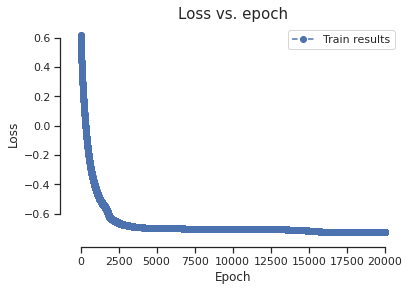

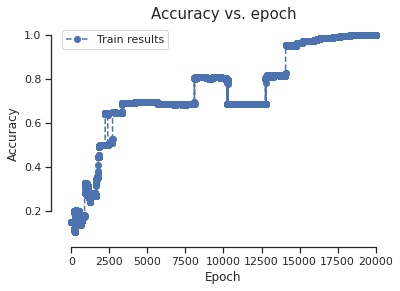

In [23]:
plot("Loss vs. epoch", "Loss", train_losses)
plot("Accuracy vs. epoch", "Accuracy", train_accs)

## Inspect model

Ground truths: tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.])
Predictions: tensor([1., 2., 3., 3., 3., 4., 4., 4., 4., 4., 4., 5., 4., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.])
Loss: 0.2583683729171753
Latents: torch.Size([10, 53, 10])


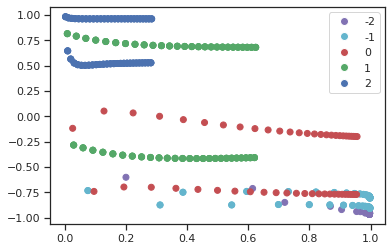

In [81]:
inspect_predictions(train_dataloader, model_to_be_inspected, round_pred=True, plot_latent_space=True)

In [25]:
print("Weights:", readout.linear.weight)

print("Biases:", readout.linear.bias)

print("Weight matrices for input-to-hidden connections:", core.gru.weight_ih)

print("Weight matrices for hidden-to-hidden connections:", core.gru.weight_hh)

print("Bias vectors for input-to-hidden connections:", core.gru.bias_ih)

print("Bias vectors for hidden-to-hidden connections:", core.gru.bias_hh)

Weights: Parameter containing:
tensor([[-3.2098, -2.1016]], requires_grad=True)
Biases: None
Weight matrices for input-to-hidden connections: Parameter containing:
tensor([[ 0.8623],
        [ 0.9166],
        [-0.9035],
        [-0.4525],
        [-0.2772],
        [-0.4196]], requires_grad=True)
Weight matrices for hidden-to-hidden connections: Parameter containing:
tensor([[ 2.1464,  3.1734],
        [ 2.2738, -3.2962],
        [-2.2121, -5.1473],
        [ 3.6216, -2.5350],
        [ 1.5822, -1.6068],
        [-0.8251,  3.7694]], requires_grad=True)
Bias vectors for input-to-hidden connections: Parameter containing:
tensor([-0.7067,  1.9801,  0.1462, -0.6719, -0.0523, -0.2198],
       requires_grad=True)
Bias vectors for hidden-to-hidden connections: Parameter containing:
tensor([0.4638, 1.9475, 0.1629, 0.1637, 1.0571, 0.3405], requires_grad=True)


## Real data

### Reach Cage data

In [72]:
dataset = ReachCageDataset('data/reach_cage_spikes.csv', n_samples=10, bin_duration=100)

In [73]:
# X
print(dataset[0][0].shape)
dataset[0][0].T

(54, 1)


array([[1, 0, 1, 0, 3, 1, 0, 1, 1, 5, 0, 2, 4, 3, 0, 0, 1, 3, 0, 1, 0, 4,
        1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 1, 4, 1, 1, 4, 3, 4, 3, 0, 4, 3, 1,
        6, 3, 0, 8, 3, 2, 0, 1, 2, 3]])

In [74]:
# Y
print(dataset[0][1].shape)
dataset[0][1].T

(54, 1)


array([[0, 1, 0, 1, 0, 3, 1, 0, 1, 1, 5, 0, 2, 4, 3, 0, 0, 1, 3, 0, 1, 0,
        4, 1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 1, 4, 1, 1, 4, 3, 4, 3, 0, 4, 3,
        1, 6, 3, 0, 8, 3, 2, 0, 1, 2]])

In [75]:
dataset = np.concatenate(dataset, axis=2)

In [77]:
X = torch.tensor(dataset[0].T, dtype=torch.float32)
print(X.shape)
X

torch.Size([10, 54])


tensor([[ 1.,  0.,  1.,  0.,  3.,  1.,  0.,  1.,  1.,  5.,  0.,  2.,  4.,  3.,
          0.,  0.,  1.,  3.,  0.,  1.,  0.,  4.,  1.,  1.,  1.,  2.,  1.,  2.,
          2.,  0.,  2.,  0.,  1.,  4.,  1.,  1.,  4.,  3.,  4.,  3.,  0.,  4.,
          3.,  1.,  6.,  3.,  0.,  8.,  3.,  2.,  0.,  1.,  2.,  3.],
        [ 2.,  2.,  0.,  1.,  1.,  2.,  0.,  1.,  0.,  0.,  2.,  2.,  1.,  0.,
          0.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,  2.,
          0.,  0.,  0.,  2.,  0.,  1.,  1.,  1.,  0.,  1.,  3.,  2.,  1.,  2.,
          0.,  0.,  2.,  0.,  4.,  2.,  1.,  3.,  0.,  1.,  0.,  1.],
        [ 4.,  0.,  3.,  2.,  2.,  4.,  1.,  2.,  1.,  2.,  0.,  0.,  0.,  0.,
          2.,  0.,  1.,  1.,  3.,  2.,  2.,  1.,  4.,  1.,  0.,  3.,  1.,  0.,
          1.,  2.,  4.,  0.,  1.,  0.,  2.,  2.,  1.,  2.,  1.,  3.,  4.,  2.,
          2.,  2.,  0.,  2.,  1.,  3.,  5.,  1.,  0.,  4.,  0.,  5.],
        [ 2.,  0.,  2.,  1.,  1.,  1.,  0.,  1.,  4.,  1.,  0.,  2.,  0.,  3.,


In [78]:
Y = torch.tensor(dataset[1].T, dtype=torch.float32)
print(Y.shape)
Y

torch.Size([10, 54])


tensor([[ 0.,  1.,  0.,  1.,  0.,  3.,  1.,  0.,  1.,  1.,  5.,  0.,  2.,  4.,
          3.,  0.,  0.,  1.,  3.,  0.,  1.,  0.,  4.,  1.,  1.,  1.,  2.,  1.,
          2.,  2.,  0.,  2.,  0.,  1.,  4.,  1.,  1.,  4.,  3.,  4.,  3.,  0.,
          4.,  3.,  1.,  6.,  3.,  0.,  8.,  3.,  2.,  0.,  1.,  2.],
        [ 4.,  2.,  2.,  0.,  1.,  1.,  2.,  0.,  1.,  0.,  0.,  2.,  2.,  1.,
          0.,  0.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,
          2.,  0.,  0.,  0.,  2.,  0.,  1.,  1.,  1.,  0.,  1.,  3.,  2.,  1.,
          2.,  0.,  0.,  2.,  0.,  4.,  2.,  1.,  3.,  0.,  1.,  0.],
        [ 2.,  4.,  0.,  3.,  2.,  2.,  4.,  1.,  2.,  1.,  2.,  0.,  0.,  0.,
          0.,  2.,  0.,  1.,  1.,  3.,  2.,  2.,  1.,  4.,  1.,  0.,  3.,  1.,
          0.,  1.,  2.,  4.,  0.,  1.,  0.,  2.,  2.,  1.,  2.,  1.,  3.,  4.,
          2.,  2.,  2.,  0.,  2.,  1.,  3.,  5.,  1.,  0.,  4.,  0.],
        [ 0.,  2.,  0.,  2.,  1.,  1.,  1.,  0.,  1.,  4.,  1.,  0.,  2.,  0.,


In [79]:
rc_dataset = CustomDataset(X, Y)
batch_size = 10
rc_dataloader = DataLoader(rc_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
hidden_size = 10
n_epochs = 20000

scheduler = StepLR(optimizer, step_size=2000, gamma=0.1)
criterion = nn.PoissonNLLLoss()
epsilon = 1e-8
loss_fn = lambda pred, target: criterion((pred+epsilon).log(), (target+epsilon))
#loss_fn = nn.MSELoss()

results = []

learning_rates = [0.005, 0.001, 0.0005]
for opt, lr in zip(repeat(torch.optim.Adam), learning_rates):
    print("Train with learning rate of", lr)

    core = GRUCore(hidden_size)
    readout = LinearReadout(hidden_size, bias=False)
    model = CoreAndReadout(core, readout)
    optimizer = opt(model.parameters(), lr=lr)
    train_losses, train_accs, _, _ = run_training(rc_dataloader, None, model, optimizer, loss_fn, n_epochs, scheduler=scheduler)
    
    results.append({'model': model, 'train_losses': train_losses, 'train_accs': train_accs, 'lr': lr})
    
    print(f"Best loss: {min(train_losses)}, best accuracy: {max(train_accs)}\n")

Train with learning rate of 0.005
Epoch 0, train loss: 0.9404853582382202, train acc: 0.3277777777777778
Epoch 1000, train loss: 0.5905227661132812, train acc: 0.3907407407407407
Epoch 2000, train loss: 0.6641800999641418, train acc: 0.39444444444444443
Epoch 3000, train loss: 0.6465678215026855, train acc: 0.3611111111111111
Epoch 4000, train loss: 0.5650990605354309, train acc: 0.42777777777777776
Epoch 5000, train loss: 0.5566473007202148, train acc: 0.45
Epoch 6000, train loss: 0.5280269384384155, train acc: 0.44814814814814813
Epoch 7000, train loss: 0.5504710078239441, train acc: 0.4185185185185185
Epoch 8000, train loss: 0.6045799255371094, train acc: 0.37777777777777777
Epoch 9000, train loss: 0.7861846089363098, train acc: 0.2833333333333333
Epoch 10000, train loss: 0.6882598400115967, train acc: 0.32222222222222224
Epoch 11000, train loss: 0.5719608664512634, train acc: 0.37222222222222223
Epoch 12000, train loss: 0.5407647490501404, train acc: 0.4148148148148148
Epoch 13000,

In [ ]:
model_index = 0
model_to_be_inspected = results[model_index]['model']
train_losses = results[model_index]['train_losses']
train_accs = results[model_index]['train_accs']

In [ ]:
plot("Loss vs. epoch", "Loss", train_losses)
plot("Accuracy vs. epoch", "Accuracy", train_accs)

In [ ]:
inspect_predictions(rc_dataloader, model_to_be_inspected, round_pred=True)

In [ ]:
print("Weights:", model_to_be_inspected.readout.linear.weight)

print("Biases:", model_to_be_inspected.readout.linear.bias)

print("Weight matrices for input-to-hidden connections:", model_to_be_inspected.core.gru.weight_ih)

print("Weight matrices for hidden-to-hidden connections:", model_to_be_inspected.core.gru.weight_hh)

print("Bias vectors for input-to-hidden connections:", model_to_be_inspected.core.gru.bias_ih)

print("Bias vectors for hidden-to-hidden connections:", model_to_be_inspected.core.gru.bias_hh)

# Upcoming todos
- read into (latent) factor analysis
- more fitting data generation/simulation? (Nonlinear general pattern + linear neuron-specific characteristics?)
- ...?